In [2]:
!pip install numba
#!pip install scikit-learn
#!pip install pydot

     ---------------------------------------- 2.5/2.5 MB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 5.8 MB/s eta 0:00:00


In [3]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.8.3


# Configurations

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [6]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


# Read Data

In [9]:
lotto = pd.read_csv('lotto_history.csv', index_col = 'Date')
lotto.head()

,Ball_1,Ball_2,Ball_3,Ball_4,Ball_5,Ball_6,Ball_Bonus
Date,,,,,,,
2016-01-02,12,25,29,40,48,56,52
2016-01-06,8,30,40,50,54,57,13
2016-01-09,26,27,46,47,52,58,48
2016-01-13,4,12,38,46,57,59,8
2016-01-16,1,8,12,25,43,52,38


# Train Test Split
Use the last 50 draws as the test dataset
Use a sliding window of 10 to split the input data

In [10]:
data = lotto.values - 1
train = data[:-50]
test = data[-50:]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [11]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(485, 7)
(425, 10, 7)
(425, 7)
(50, 10, 7)
(50, 7)


# Seq2Seq Model to Predict Future Draws

Input the last 10 draws and sequentially predict the next draw.
Monitor the performance by sparse categorical crossentropy and sparse top k categorical accuracy.

In [14]:
embed_dim = (59 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 7
feature_count = embed_dim * 7
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [15]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 59 categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(59, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(59, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(59, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(59, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(59, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(59, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(59, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(59, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                              

                                                                  'bidirectional[0][4]']          
                                                                                                  
 lstm_2 (LSTM)                  (None, 7, 128)       98816       ['repeat_vector[0][0]',          
                                                                  'concatenate_1[0][0]',          
                                                                  'concatenate_2[0][0]']          
                                                                                                  
 concatenate_4 (Concatenate)    (None, 64)           0           ['bidirectional_1[0][2]',        
                                                                  'bidirectional_1[0][4]']        
                                                                                                  
 lstm_3 (LSTM)                  (None, 7, 64)        49408       ['lstm_2[0][0]',                 
          

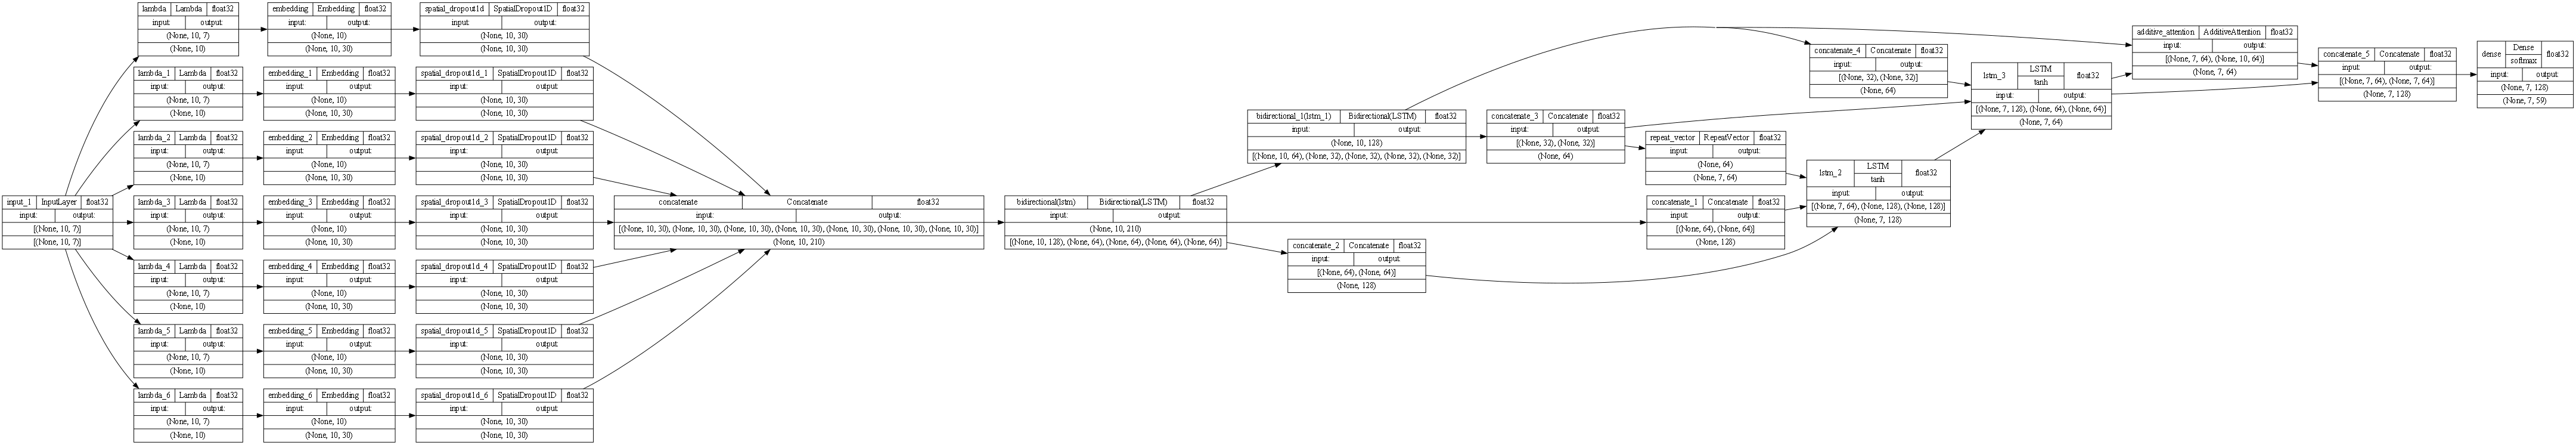

In [30]:
plot_model(model, 
           to_file='lotto_prediction.png',
           show_shapes = True, 
           show_dtype=True,
           show_layer_names = True, 
           rankdir = 'LR', #'TB',
           expand_nested=True,
           dpi = 70,
           show_layer_activations = True)

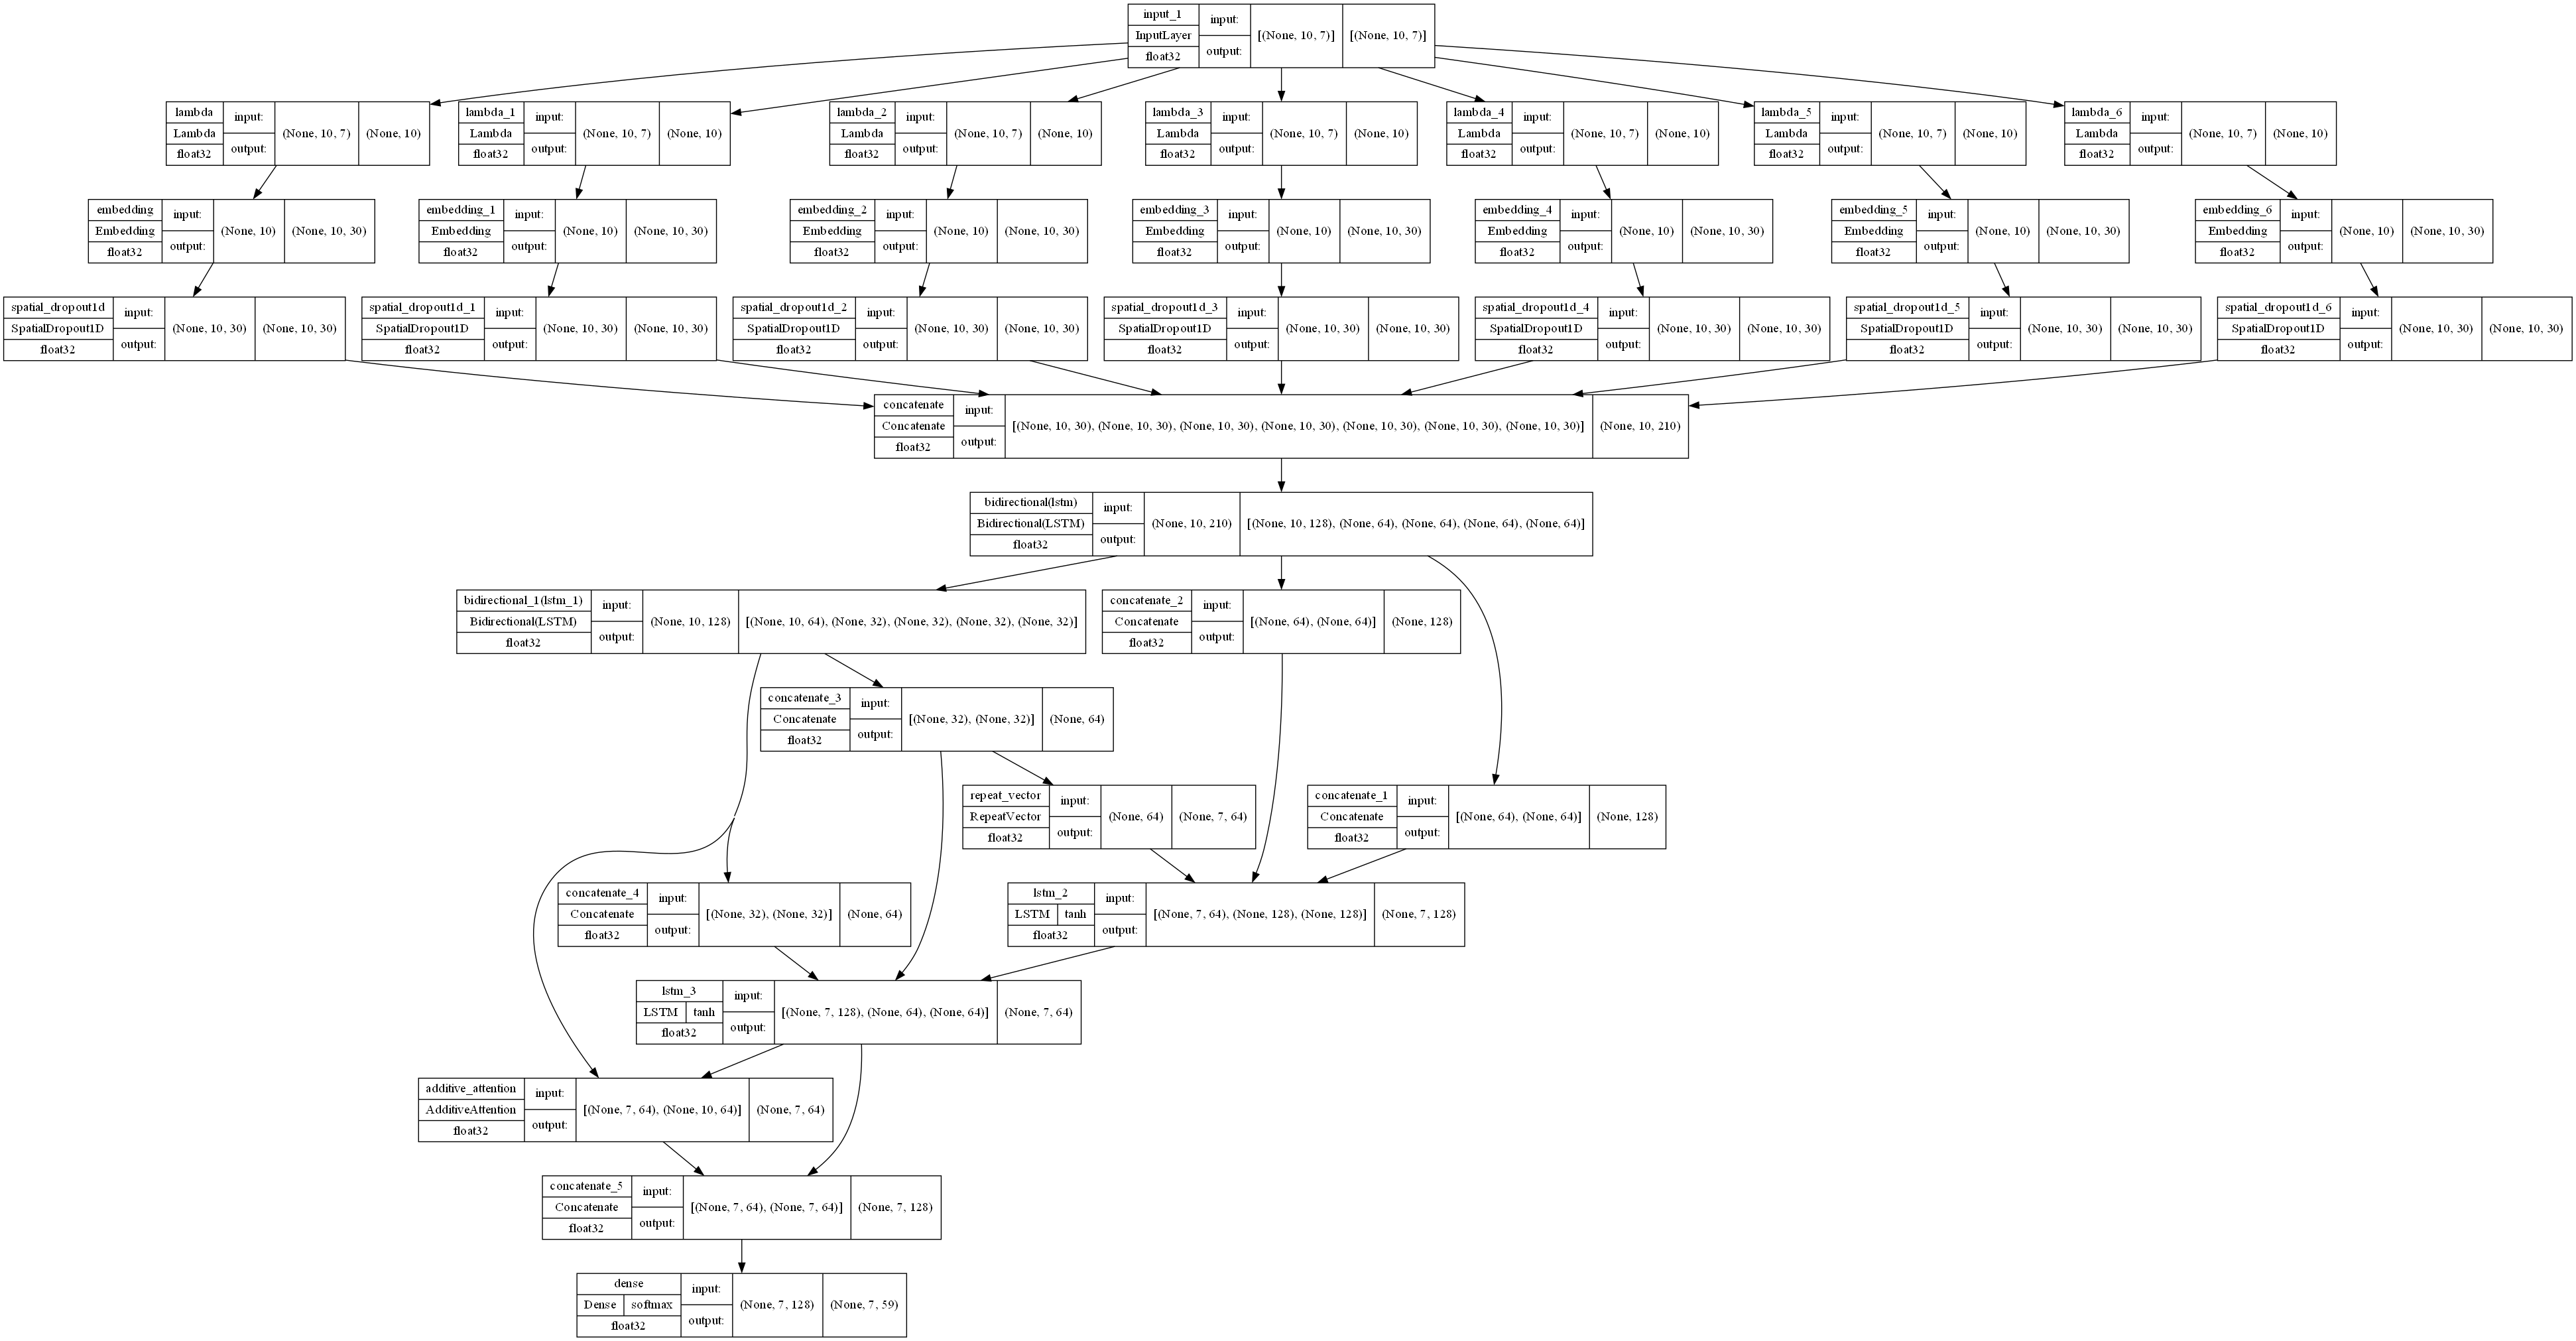

In [24]:
plot_model(model, 
           to_file='Lotto_Prediction.png',
           show_shapes = True, 
           show_dtype=True,
           show_layer_names = True, 
           rankdir ='TB',
           expand_nested=True,
           dpi = 100,
           show_layer_activations = True)

In [18]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [19]:
EPOCHS = 200
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/200
14/14 - 10s - loss: 4.0777 - sparse_top_k: 0.0793 - val_loss: 4.0773 - val_sparse_top_k: 0.1000 - lr: 1.0000e-04 - 10s/epoch - 742ms/step
Epoch 2/200
14/14 - 0s - loss: 4.0768 - sparse_top_k: 0.0928 - val_loss: 4.0771 - val_sparse_top_k: 0.0886 - lr: 9.9994e-05 - 290ms/epoch - 21ms/step
Epoch 3/200
14/14 - 0s - loss: 4.0763 - sparse_top_k: 0.1099 - val_loss: 4.0769 - val_sparse_top_k: 0.0743 - lr: 9.9978e-05 - 292ms/epoch - 21ms/step
Epoch 4/200
14/14 - 0s - loss: 4.0757 - sparse_top_k: 0.1012 - val_loss: 4.0767 - val_sparse_top_k: 0.0686 - lr: 9.9950e-05 - 289ms/epoch - 21ms/step
Epoch 5/200
14/14 - 0s - loss: 4.0748 - sparse_top_k: 0.1103 - val_loss: 4.0764 - val_sparse_top_k: 0.0743 - lr: 9.9911e-05 - 284ms/epoch - 20ms/step
Epoch 6/200
14/14 - 0s - loss: 4.0743 - sparse_top_k: 0.1045 - val_loss: 4.0760 - val_sparse_top_k: 0.0714 - lr: 9.9861e-05 - 287ms/epoch - 20ms/step
Epoch 7/200
14/14 - 0s - loss: 4.0737 - sparse_top_k: 0.1136 - val_loss: 4.0756 - val_sparse_top_k: 

Epoch 56/200
14/14 - 0s - loss: 3.6271 - sparse_top_k: 0.2635 - val_loss: 3.7292 - val_sparse_top_k: 0.1914 - lr: 8.4225e-05 - 388ms/epoch - 28ms/step
Epoch 57/200
14/14 - 0s - loss: 3.6297 - sparse_top_k: 0.2518 - val_loss: 3.7319 - val_sparse_top_k: 0.2086 - lr: 8.3684e-05 - 390ms/epoch - 28ms/step
Epoch 58/200
14/14 - 0s - loss: 3.6246 - sparse_top_k: 0.2461 - val_loss: 3.7263 - val_sparse_top_k: 0.2114 - lr: 8.3136e-05 - 454ms/epoch - 32ms/step
Epoch 59/200
14/14 - 0s - loss: 3.6211 - sparse_top_k: 0.2568 - val_loss: 3.7265 - val_sparse_top_k: 0.2057 - lr: 8.2581e-05 - 355ms/epoch - 25ms/step
Epoch 60/200
14/14 - 0s - loss: 3.6192 - sparse_top_k: 0.2598 - val_loss: 3.7254 - val_sparse_top_k: 0.2086 - lr: 8.2019e-05 - 364ms/epoch - 26ms/step
Epoch 61/200
14/14 - 0s - loss: 3.6153 - sparse_top_k: 0.2669 - val_loss: 3.7220 - val_sparse_top_k: 0.2086 - lr: 8.1450e-05 - 372ms/epoch - 27ms/step
Epoch 62/200
14/14 - 0s - loss: 3.6072 - sparse_top_k: 0.2528 - val_loss: 3.7200 - val_sparse_

Epoch 111/200
14/14 - 0s - loss: 3.5319 - sparse_top_k: 0.2713 - val_loss: 3.7004 - val_sparse_top_k: 0.1743 - lr: 4.7960e-05 - 371ms/epoch - 26ms/step
Epoch 112/200
14/14 - 0s - loss: 3.5400 - sparse_top_k: 0.2706 - val_loss: 3.7025 - val_sparse_top_k: 0.1714 - lr: 4.7263e-05 - 434ms/epoch - 31ms/step
Epoch 113/200
14/14 - 0s - loss: 3.5373 - sparse_top_k: 0.2743 - val_loss: 3.6956 - val_sparse_top_k: 0.1886 - lr: 4.6568e-05 - 388ms/epoch - 28ms/step
Epoch 114/200
14/14 - 0s - loss: 3.5368 - sparse_top_k: 0.2753 - val_loss: 3.7046 - val_sparse_top_k: 0.1743 - lr: 4.5875e-05 - 392ms/epoch - 28ms/step
Epoch 115/200
14/14 - 0s - loss: 3.5336 - sparse_top_k: 0.2726 - val_loss: 3.7006 - val_sparse_top_k: 0.1800 - lr: 4.5184e-05 - 414ms/epoch - 30ms/step
Epoch 116/200
14/14 - 0s - loss: 3.5289 - sparse_top_k: 0.2760 - val_loss: 3.6991 - val_sparse_top_k: 0.1743 - lr: 4.4495e-05 - 358ms/epoch - 26ms/step
Epoch 117/200
14/14 - 0s - loss: 3.5260 - sparse_top_k: 0.2861 - val_loss: 3.7038 - val_

Epoch 165/200
14/14 - 0s - loss: 3.5050 - sparse_top_k: 0.2884 - val_loss: 3.6933 - val_sparse_top_k: 0.1771 - lr: 1.7005e-05 - 438ms/epoch - 31ms/step
Epoch 166/200
14/14 - 1s - loss: 3.5155 - sparse_top_k: 0.2810 - val_loss: 3.6928 - val_sparse_top_k: 0.1800 - lr: 1.6631e-05 - 585ms/epoch - 42ms/step
Epoch 167/200
14/14 - 1s - loss: 3.5002 - sparse_top_k: 0.2807 - val_loss: 3.6942 - val_sparse_top_k: 0.1829 - lr: 1.6267e-05 - 622ms/epoch - 44ms/step
Epoch 168/200
14/14 - 1s - loss: 3.5050 - sparse_top_k: 0.2830 - val_loss: 3.6911 - val_sparse_top_k: 0.1829 - lr: 1.5912e-05 - 582ms/epoch - 42ms/step
Epoch 169/200
14/14 - 0s - loss: 3.5013 - sparse_top_k: 0.2803 - val_loss: 3.6910 - val_sparse_top_k: 0.1829 - lr: 1.5566e-05 - 415ms/epoch - 30ms/step
Epoch 170/200
14/14 - 0s - loss: 3.5103 - sparse_top_k: 0.2807 - val_loss: 3.6960 - val_sparse_top_k: 0.1743 - lr: 1.5231e-05 - 429ms/epoch - 31ms/step
Epoch 171/200
14/14 - 0s - loss: 3.5026 - sparse_top_k: 0.2743 - val_loss: 3.6923 - val_

In [ ]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

# Predict the Test Dataset

In [ ]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

In [ ]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

# Predict the Future Draw on 2020/Aug/26
The Beam Search method is use to output 10 possible draws.
It is worth noting that Replace = False means no duplicate balls.

In [25]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, 7)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[ 2  7 11 23 37 45 19]
  [10 13 14 18 33 34 15]
  [ 1 24 39 46 49 52 51]
  [ 4 10 13 24 53 56 22]
  [ 1 28 42 43 51 58 36]
  [ 2 40 49 53 56 58 41]
  [ 6  8 27 31 37 51 20]
  [10 14 16 22 25 34 21]
  [21 22 32 36 45 50  5]
  [19 23 24 28 37 51 12]]]


In [26]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [27]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

[ 2 16 25 35 47 58 58]


In [28]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 2 16 25 35 47 58 58] 	Log Likelihood:  -20.062469848796677
Prediction:  [ 2 16 25 35 45 58 58] 	Log Likelihood:  -20.07747108084795
Prediction:  [ 2 16 26 35 47 58 58] 	Log Likelihood:  -20.078793081383264
Prediction:  [ 5 16 25 35 47 58 58] 	Log Likelihood:  -20.087042178875322
Prediction:  [ 2 16 26 35 45 58 58] 	Log Likelihood:  -20.093794313434536
Prediction:  [ 5 16 25 35 45 58 58] 	Log Likelihood:  -20.102043410926594
Prediction:  [ 5 16 26 35 47 58 58] 	Log Likelihood:  -20.103365411461905
Prediction:  [ 1 16 25 35 47 58 58] 	Log Likelihood:  -20.105053564618615
Prediction:  [ 2 14 25 35 47 58 58] 	Log Likelihood:  -20.1080181441481
Prediction:  [ 2 16 29 35 47 58 58] 	Log Likelihood:  -20.116974372260675


In [29]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 2 16 25 35 47 58 59] 	Log Likelihood:  -20.15269545023026
Prediction:  [ 2 16 25 35 45 58 59] 	Log Likelihood:  -20.167696682281534
Prediction:  [ 2 16 26 35 47 58 59] 	Log Likelihood:  -20.169018682816848
Prediction:  [ 5 16 25 35 47 58 59] 	Log Likelihood:  -20.177267780308906
Prediction:  [ 2 16 26 35 45 58 59] 	Log Likelihood:  -20.18401991486812
Prediction:  [ 5 16 25 35 45 58 59] 	Log Likelihood:  -20.19226901236018
Prediction:  [ 5 16 26 35 47 58 59] 	Log Likelihood:  -20.19359101289549
Prediction:  [ 1 16 25 35 47 58 59] 	Log Likelihood:  -20.1952791660522
Prediction:  [ 2 14 25 35 47 58 59] 	Log Likelihood:  -20.198243745581685
Prediction:  [ 2 16 29 35 47 58 59] 	Log Likelihood:  -20.20719997369426
